# DeepNeuralNetwork(Tensorflow)

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

### 1 Load data

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

### 2 Reshape data

In [4]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T / 255
train_y = train_y.reshape(-1,1).T
test_y = test_y.reshape(-1,1).T
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(12288, 209)
Test_x's shape:(12288, 50)
Train_y's shape:(1, 209)
Test_y's shape:(1, 50)


### 3 IniInitialization Parameters 

(1) layers:传入的是一个```input+layers```的形式,所以我们需要使用for loop将$weights$和$bias$一次性创建出来.

其中

$W:$(units,inputs)

$b:$(units,1)

(2) 使用```xavier_initializer```初始化

```python
tf.contrib.layers.xavier_initializer(seed=1)```

(3) 我们需要定义tensor $W,b$的name,以便于我们在最后模型训练完毕之后更新Parameters.

In [5]:
def inital_parameters(layers):
    """
    Initialization Parameters 
    Prameters:
    ---------
        layers:Model layers layers:input+layers
        
    Return:
    ------
        paramters: weights and bias
    """
    tf.set_random_seed(0)
    L = len(layers)
    paramters = {}
    for l in range(1,L):
        W = tf.get_variable('W'+str(l),[layers[l],layers[l-1]],
                            initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b = tf.Variable(tf.zeros([layers[l],1]),name='b'+str(l))
        paramters['W'+str(l)] = W
        paramters['b'+str(l)] = b
    
    return paramters

因为我们一旦创建完毕一个tensor就无法再次创建相同的tensor,所以使用```tf.reset_default_graph()```可以使得我们多次创建tensor.

[tf.reset_default_graph()](https://www.tensorflow.org/api_docs/python/tf/reset_default_graph)清除重置计算图

In [6]:
tf.reset_default_graph()
with tf.Session() as sess:
    layers = [train_x.shape[0],20,7,5,1]
    parameters = inital_parameters(layers)
    init = tf.global_variables_initializer()
    sess.run(init)
    for key,value in parameters.items():
        print(key,value)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 <tf.Variable 'W1:0' shape=(20, 12288) dtype=float32_ref>
b1 <tf.Variable 'b1:0' shape=(20, 1) dtype=float32_ref>
W2 <tf.Variable 'W2:0' shape=(7, 20) dtype=float32_ref>
b2 <tf.Variable 'b2:0' shape=(7, 1) dtype=float32_ref>
W3 <tf.Variable 'W3:0' shape=(5, 7) dtype=float32_ref>
b3 <tf.Variable 'b3:0' shape=(5, 1) dtype=float32_ref>
W4 <tf.Variable 'W4:0' shape=(1, 5) dtype=float32_ref>
b4 <tf.Variable 'b4:0' shape=(1, 1) dtype=float32_ref>


可以看到当$layers=[trainx.shape[0],20,7,5,1]$的时候,创建的参数形状是正确的.

### 4 Build Forward Propagation 

创建向前传播

我们需要计算线性值,以及在hidden layers使用ReLu激活函数.

所以:

(1) 使用循环将参数$W,b$取出进行计算线性值.

```python
for l in range(1,L):
    W = parameters['W'+str(l)]
    b = parameters['b'+str(l)]
    Z = tf.add(tf.matmul(W,A),b)```

(2) 我们只需要计算$L-1$层的ReLu,因为最后一层(output layer)我们是使用sigmoid函数

```python
if l != L-1:
    A = tf.nn.relu(Z)```
    
(3) 我们一定要备份一次初始的$X$,如果不备份,那么多次计算之后$X$的形状就会改变,从而tensor在计算BackWard的时候会错误

以下是**错误代码:**

```python
Z = tf.add(tf.matmul(W,X),b)
X = tf.nn.relu(Z)```


In [7]:
def forward(X,parameters,L):
    """
    Build forward paopagation
    Parameters:
    ----------
        X: training data
        parameters: weights and bias
        L: length of layers
        
    Return:
    ------
        Z: last layer linear value.
    """
    A = X # cache X 
    for l in range(1,L):
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        Z = tf.add(tf.matmul(W,A),b)
        if l != L-1:
            A = tf.nn.relu(Z)
    return Z

### 5 Build TF of DNN

构建DNN模型

整体结构为:

(1) 创建占位符,由于有batch的存在,样本个数为None.

```python
X = tf.placeholder(tf.float32,[n,None])
y = tf.placeholder(tf.float32,[1,None])
```

(2) 初始化参数$W,b$

```python
parameters = inital_parameters(layers)```

(3) Forward 

```python
Z = forward(X,parameters,L)```

(4) 计算cost,使用```tf.nn.sigmoid_cross_entropy_with_logits```,故FP的output layer无需计算sigmoid.

```python
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=y))```

(5) Optimizer and Update

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(cost)```

(6) 计算每setp的accuracy

```python
correct_ = tf.equal(tf.round(tf.sigmoid(Z)),y)
accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))```

(7) 启动TF训练模型

```python
with tf.Session() as sess:
    ....```
    
 
**Ps:**

(1) 由于之前我们在测试的时候已经创建了$W,b$所以这里需要清除之前所有存在的计算图

```python
ops.reset_default_graph()```

(2) 当模型训练完毕之后,我们需要更新Parameters中的参数

(2.1) ```graph = tf.get_default_graph()```获取所有的计算图

(2.2) 将所有的$W,b$依照tensor name获取出来,并更新Parameters

```python
for l in range(1,L):
    W = graph.get_tensor_by_name('W'+str(l)+":0")
    b = graph.get_tensor_by_name('b'+str(l)+":0")
    parameters['W'+str(l)] = sess.run(W)
    parameters['b'+str(l)] = sess.run(b)```

In [8]:
def Model(data,labels,layers,alpha,Iter,is_print=False):
    """
    Using TF to build DNN Model.
    
    Parameters:
    ----------
        data: training data.
        labels: training labels.
        layers: define layers,just set #layer
        alpha: learning rate.
        Iter: #Iterate 
        is_print: print loss if True.default False
        
    Rerurns:
    -------
        parameters: The best weights and bias.
        L: length of layers.
    """
    ops.reset_default_graph() # rest or clear graph
    
    # create placeholder
    n,m = data.shape
    X = tf.placeholder(tf.float32,[n,None])
    y = tf.placeholder(tf.float32,[1,None])
    
    # splice layers
    layers.insert(0,n)
    L = len(layers)
    
    # initialization parameters
    parameters = inital_parameters(layers)
    
    # forward 
    Z = forward(X,parameters,L)
    
    # compute loss and optimizer loss(Update weights and bias)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(cost)
    
    # compute accuracy in every 100 setp
    correct_ = tf.equal(tf.round(tf.sigmoid(Z)),y)
    accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))
    
    init = tf.global_variables_initializer()
    
    # start TF to training.
    with tf.Session() as sess:
        sess.run(init)
        
        costs = []
        accuracys = []
        for iter_ in range(Iter):
            _,loss = sess.run([optimizer,cost],feed_dict={X:data,y:labels})
            
            if iter_ % 1000== 0 and is_print:
                print('After iter {} loss {}'.format(iter_,loss))
            if iter_ % 100 == 0:
                acc = sess.run([accuracy],feed_dict={X:data,y:labels})
                costs.append(loss)
                accuracys.append(acc)
        
        # when for loop was over,then we need update parameters.
        graph = tf.get_default_graph()
        for l in range(1,L):
            W = graph.get_tensor_by_name('W'+str(l)+":0")
            b = graph.get_tensor_by_name('b'+str(l)+":0")
            parameters['W'+str(l)] = sess.run(W)
            parameters['b'+str(l)] = sess.run(b)
        
        # plot loss and accuracy
        plt.plot(costs,c='orange',label='loss')
        plt.plot(accuracys,c='green',label='accuracy')
        plt.title('Lr:{}'.format(alpha))
        plt.xlabel('Iteration')
        plt.ylabel('value')
        plt.legend()
        plt.show()
        
        
        return parameters,L
    

After iter 0 loss 0.7148303985595703
After iter 1000 loss 0.35281920433044434
After iter 2000 loss 0.17369429767131805


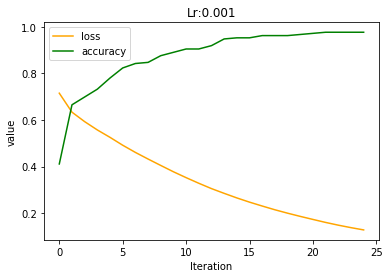

In [9]:
parameters,L = Model(data=train_x,labels=train_y,layers=[20,7,5,1],alpha=0.001,Iter=2500,is_print=True)

可以看到loss逐渐下降而accuracy逐渐升高.

### 6 Score and Predict

现在定义评分函数和预测函数.

In [10]:
def score(data,labels,parameters,L):
    """
    Score Model
    Parameters:
    ----------
       data: score data
       labels: true labels.
       parameters: weights and bias
       L : length of layers
    Return:
    ------
       acc: correct rate. 
    """
    n,m = data.shape
    X = tf.placeholder(tf.float32,shape=[n,None])
    y = tf.placeholder(tf.float32,shape=[1,None])
    Z = forward(X,parameters,L)
    predict = tf.round(tf.sigmoid(Z))
    correct_ = tf.equal(predict,y)
    accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        acc = sess.run(accuracy,feed_dict={X:data,y:labels})
        
        return acc
    

In [11]:
acc = score(train_x,train_y,parameters,L)
print('The training set accuracy {}'.format(acc))

The training set accuracy 0.9760765433311462


In [12]:
acc = score(test_x,test_y,parameters,L)
print('The testing set accuracy {}'.format(acc))

The testing set accuracy 0.800000011920929


可以看到测试样本和训练样本的正确率都是在可接受的范围内.

In [13]:
def predict(data,parameters,L):
    """
    predict label
    Parameters:
    ----------
       data: predict data
       parameters: weights and bias
       L : length of layers
    Return:
    ------
       predict_y: predict label.
    """
    n,m = data.shape
    X = tf.placeholder(tf.float32,shape=[n,None])
    y = tf.placeholder(tf.float32,shape=[1,None])
    Z = forward(X,parameters,L)
    predict_ = tf.round(tf.sigmoid(Z))
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        predict_y = sess.run(predict_,feed_dict={X:data})
        if predict_y == 1:
            print("It's a cat.")
        else:
            print('Not cat.')
        return predict_y
    

来一张图片测试一下

In [14]:
from skimage import transform

In [15]:
image_path = '../picture/cat.jpg'
image = plt.imread(image_path)

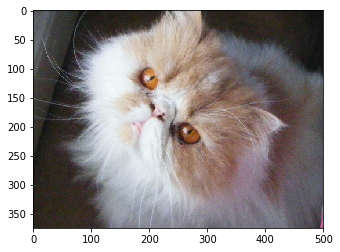

In [16]:
plt.imshow(image)

因为我们训练图片的大小是(64,64,3)的,所以在测试的时候我们也需要将其转换为(64,64)的形式

In [17]:
image_resize = transform.resize(image,output_shape=(64,64))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
test_image = image_resize.reshape(-1,1)
predict(test_image,parameters,L)

It's a cat.


array([[1.]], dtype=float32)